In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
from scipy import interpolate
import scipy
import scipy.special
import scipy.integrate

In [2]:
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = "\usepackage{subdepth}, \usepackage{type1cm}"

In [73]:
#z_pk = [200.0,100.0,75.0,50.0,10.0,5.0,0.0]
z_pk = [100.0,10.0,5.0,3.0,1.0,0.5,0.0]
z_init = 300.
cosmo = Class()
cosmo.set({'output':'mPk dTk vTk lTk', 
           'z_pk':str(z_pk).strip('[]'),
           'a_init_nbody': 1./(z_init+1.),
           'switch_radiation_source':1,
                  'switch_dr_source':1,
           'switch_gamma':1,
           'radiation_streaming_approximation':3,
           'ur_fluid_approximation':3,
           'l_max_g':200,
           'l_max_ur':200,
           'l_max_pol_g':200, 
           'reio_parametrization':'reio_none',
           'k_per_decade_for_pk':100,
           'k_per_decade_for_bao':200,
           'gauge' : 'Newtonian',
           'P_k_max_1/Mpc' : 1.1,
           'evolver':0,
           'tol_perturb_integration':0.000001,
           'tol_background_integration':1e-8,
           'back_integration_stepsize':1e-3,
           'perturb_sampling_stepsize':0.01,
           'tol_thermo_integration':1e-5,
           'Omega_cdm':0.24*1+1e-6,
                  'start_sources_at_tau_c_over_tau_h':0.004,
                  'start_small_k_at_tau_c_over_tau_h':0.000015
            })
#for key, val in cosmo.pars.iteritems():
#    print key,' = ',val
cosmo.compute()

In [128]:
bg = cosmo.get_background()

grow_interp_z = interpolate.interp1d(bg['z'],bg['grow'])
decay_interp_z = interpolate.interp1d(bg['z'],bg['bwdec'])
rho_cdm_interp_z = interpolate.interp1d(bg['z'],bg['(.)rho_cdm'])
rho_b_interp_z = interpolate.interp1d(bg['z'],bg['(.)rho_b'])
rho_lambda_interp_z = interpolate.interp1d(bg['z'],bg['(.)rho_lambda'])
rho_ur_interp_z = interpolate.interp1d(bg['z'],bg['(.)rho_ur'])
rho_g_interp_z = interpolate.interp1d(bg['z'],bg['(.)rho_g'])

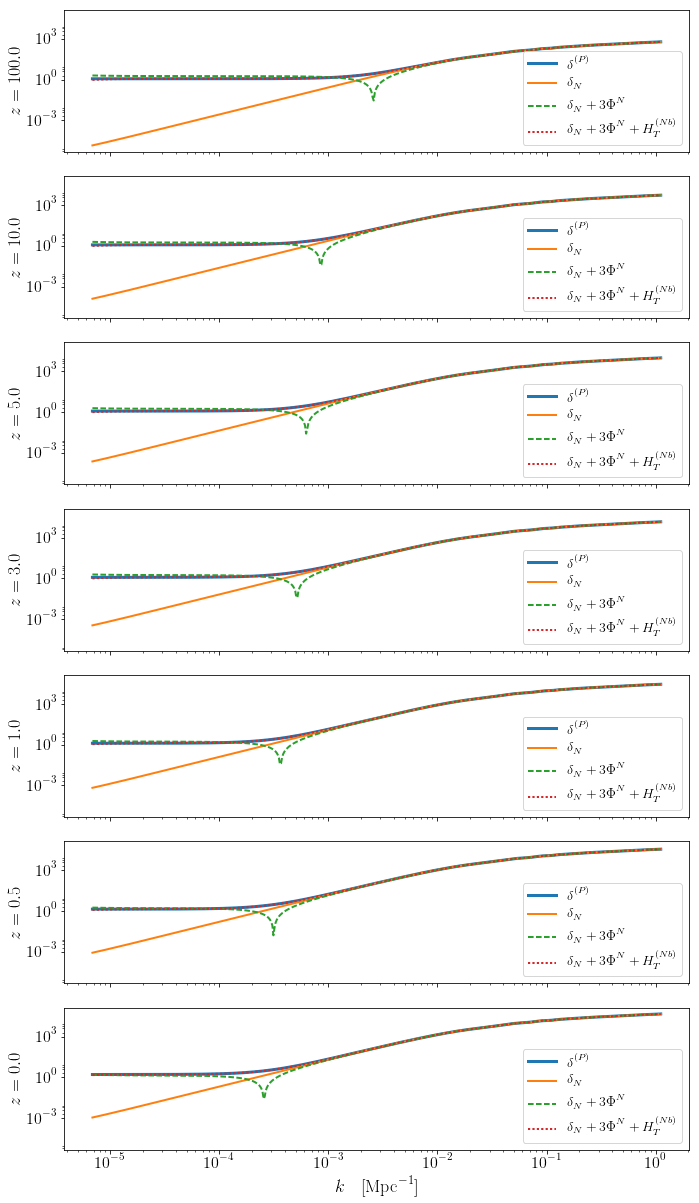

In [75]:
zvec = z_pk
f, axes = plt.subplots(len(zvec),1,figsize=(10,17),sharex=True,sharey=True)
tk0 = cosmo.get_transfer(0.)
CHT_grow0 = tk0['delta_Nb']
CHT_decay0 = tk0['theta_Nb']

for iz, z in enumerate(zvec):
    a = 1./(1.+z)
    tk = cosmo.get_transfer(z)
    k = tk['k (h/Mpc)']*cosmo.h()
    CHT_grow = tk['delta_Nb']
    CHT_decay = tk['theta_Nb']
    H_T_nb = tk['L_prime']
    L = tk['L']
    H_T_nm = H_T_nb - k*L
    H_T_bs = H_T_nb + (CHT_grow-CHT_grow0)*grow_interp_z(z)+(CHT_decay - CHT_decay0)*decay_interp_z(z)
 
    #delta_N = tk['delta_N']
    delta_N = (tk0['delta_N']-k*tk0['L'])*D(a)
    rho_cdm = rho_cdm_interp_z(z)
    rho_b = rho_b_interp_z(z)
    Phi_N = -3./(2.*k**2)*a*a*(rho_cdm+rho_b)*delta_N
    
    delta_P = (rho_cdm*tk['d_cdm']+rho_b*tk['d_b'])/(rho_cdm+rho_b)
    
    axes[iz].loglog(k,np.abs(delta_P),label=r'$\delta^{(P)}$',lw=3)
    axes[iz].loglog(k,np.abs(delta_N),label=r'$\delta_N$')
    axes[iz].loglog(k,np.abs(delta_N+3*Phi_N),label=r'$\delta_N + 3\Phi^N$',ls='--')
    axes[iz].loglog(k,np.abs(delta_N+3*Phi_N+H_T_nb),label=r'$\delta_N + 3\Phi^N + H_T^{(Nb)}$',ls=':',lw=2)
    #axes[iz].semilogx(k,delta_P,label=r'$\delta^{(P)}$',lw=3)
    #axes[iz].semilogx(k,delta_N,label=r'$\delta_N$')
    #axes[iz].semilogx(k,delta_N+3*Phi_N,label=r'$\delta_N + 3\Phi^N$',ls='--')
    #axes[iz].semilogx(k,delta_N+3*Phi_N+H_T_nb,label=r'$\delta_N + 3\Phi^N + H_T^{(Nb)}$',ls=':',lw=2)
    
    
    axes[iz].legend(loc='lower right')
    axes[iz].set_ylabel(r'$z='+str(z)+'$')
    #axes[iz].set_yscale('symlog',linthreshy=1e-1)

axes[-1].set_xlabel(r'$k\quad[\mathrm{Mpc}^{-1}]$')
f.tight_layout()
f.savefig('delta1.pdf')
#lgd = axes[1].legend(fontsize=fs,loc='upper center',ncol=len(zvec),
#                bbox_to_anchor=(0.5, 1.6), handletextpad=0.1)

#        axes[0].set_ylim([-4,1])
#f.subplots_adjust(wspace=0.5)

#f.savefig('H_T_influence.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')

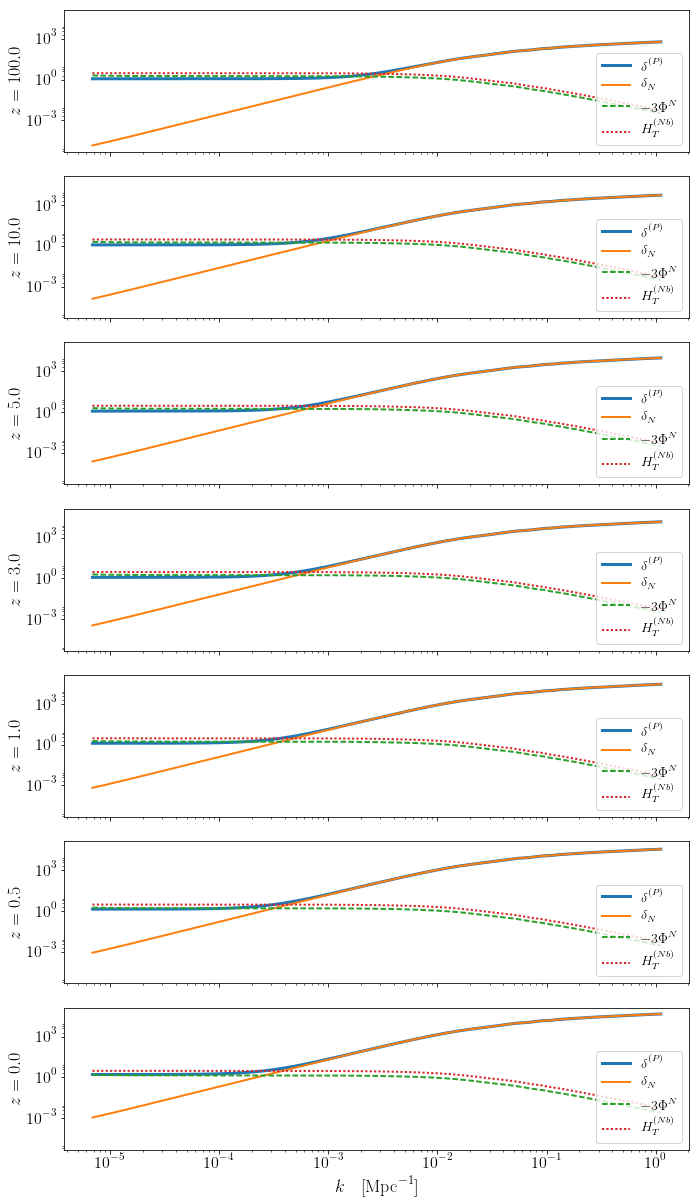

In [76]:
zvec = z_pk
f, axes = plt.subplots(len(zvec),1,figsize=(10,17),sharex=True,sharey=True)
tk0 = cosmo.get_transfer(0.)
CHT_grow0 = tk0['delta_Nb']
CHT_decay0 = tk0['theta_Nb']

for iz, z in enumerate(zvec):
    a = 1./(1.+z)
    tk = cosmo.get_transfer(z)
    k = tk['k (h/Mpc)']*cosmo.h()
    CHT_grow = tk['delta_Nb']
    CHT_decay = tk['theta_Nb']
    H_T_nb = tk['L_prime']
    L = tk['L']
    H_T_nm = H_T_nb - k*L
    H_T_bs = H_T_nb + (CHT_grow-CHT_grow0)*grow_interp_z(z)+(CHT_decay - CHT_decay0)*decay_interp_z(z)
 
    #delta_N = tk['delta_N']
    delta_N = (tk0['delta_N']-k*tk0['L'])*D(a)
    rho_cdm = rho_cdm_interp_z(z)
    rho_b = rho_b_interp_z(z)
    Phi_N = -3./(2.*k**2)*a*a*(rho_cdm+rho_b)*delta_N
    
    delta_P = (rho_cdm*tk['d_cdm']+rho_b*tk['d_b'])/(rho_cdm+rho_b)
    
    fac = 1.0#-1./k**2
    axes[iz].semilogx(k,-delta_P,label=r'$\delta^{(P)}$',lw=3)
    axes[iz].semilogx(k,-delta_N,label=r'$\delta_N$')
    axes[iz].semilogx(k,3*Phi_N,label=r'$-3\Phi^N$',ls='--')
    axes[iz].semilogx(k,-H_T_nb,label=r'$H_T^{(Nb)}$',ls=':',lw=2)
    
    
    axes[iz].legend(loc='lower right')
    axes[iz].set_ylabel(r'$z='+str(z)+'$')
    axes[iz].set_yscale('log',linthreshy=1e-1)

axes[-1].set_xlabel(r'$k\quad[\mathrm{Mpc}^{-1}]$')
f.tight_layout()
f.savefig('delta2.pdf')
#lgd = axes[1].legend(fontsize=fs,loc='upper center',ncol=len(zvec),
#                bbox_to_anchor=(0.5, 1.6), handletextpad=0.1)

#        axes[0].set_ylim([-4,1])
#f.subplots_adjust(wspace=0.5)

#f.savefig('H_T_influence.pdf',bbox_extra_artists=(lgd,), bbox_inches='tight')

1.21870758651e-08
1.21870813352e-08
1.21870782255e-08
1.21870838275e-08
1.21870785502e-08
1.21870842844e-08
1.21870754391e-08


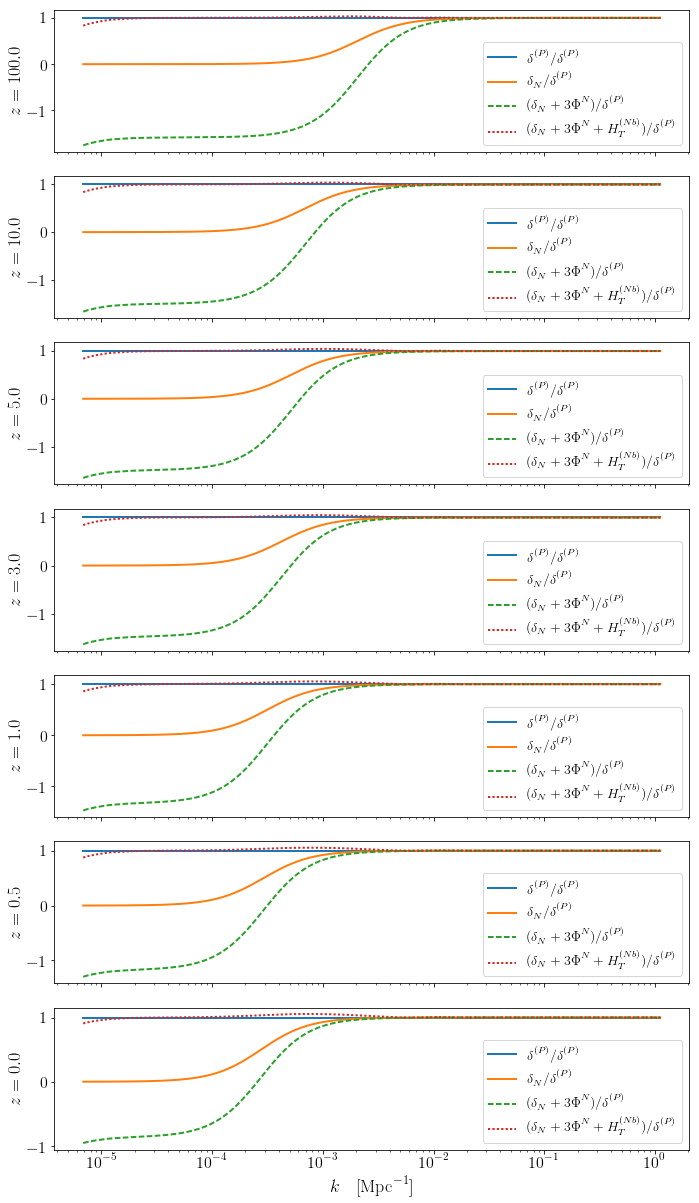

In [106]:
zvec = z_pk
f, axes = plt.subplots(len(zvec),1,figsize=(10,17),sharex=True)
tk0 = cosmo.get_transfer(0.)
bg = cosmo.get_background()
D = interpolate.UnivariateSpline(1./(1+bg['z']),bg['grow']/bg['grow'][-1],s=0)

CHT_grow0 = tk0['delta_Nb']
CHT_decay0 = tk0['theta_Nb']

for iz, z in enumerate(zvec):
    a = 1./(1.+z)
    tk = cosmo.get_transfer(z)
    k = tk['k (h/Mpc)']*cosmo.h()
    CHT_grow = tk['delta_Nb']
    CHT_decay = tk['theta_Nb']
    H_T_nb = tk['L_prime']
    L = tk['L']
    H_T_nm = H_T_nb - k*L
    H_T_bs = H_T_nb + (CHT_grow-CHT_grow0)*grow_interp_z(z)+(CHT_decay - CHT_decay0)*decay_interp_z(z)
 
    #delta_N = tk['delta_N']
    delta_N = (tk0['delta_N']-k*tk0['L'])*D(a)
    rho_cdm = rho_cdm_interp_z(z)
    rho_b = rho_b_interp_z(z)
    Phi_N = -3./(2.*k**2)*a*a*(rho_cdm+rho_b)*delta_N
    
    delta_P = (rho_cdm*tk['d_cdm']+rho_b*tk['d_b'])/(rho_cdm+rho_b)
    
    axes[iz].semilogx(k,delta_P/delta_P,label=r'$\delta^{(P)}/\delta^{(P)}$')
    axes[iz].semilogx(k,delta_N/delta_P,label=r'$\delta_N/\delta^{(P)}$')
    axes[iz].semilogx(k,(delta_N+3*Phi_N)/delta_P,label=r'$(\delta_N + 3\Phi^N)/\delta^{(P)}$',ls='--')
    axes[iz].semilogx(k,(delta_N+3*Phi_N+H_T_nm)/delta_P,label=r'$(\delta_N + 3\Phi^N + H_T^{(Nb)})/\delta^{(P)}$',ls=':')
    
    axes[iz].legend(loc='lower right')
    axes[iz].set_ylabel(r'$z='+str(z)+'$')

axes[-1].set_xlabel(r'$k\quad[\mathrm{Mpc}^{-1}]$')
f.tight_layout()
f.savefig('delta3.pdf')

['(.)rho_crit', 'grow_prime', 'bwdec', '(.)rho_cdm', 'H_prime', '(.)rho_ur', 'ang.diam.dist.', 'proper time [Gyr]', 'H [1/Mpc]', 'conf. time [Mpc]', 'bwdec_prime', 'lum. dist.', 'gr.fac. f', 'comov.snd.hrz.', 'grow', 'comov. dist.', 'Wronskian', '(.)rho_lambda', 'decay', '(.)rho_b', '(.)rho_g', 'gr.fac. D', 'z']


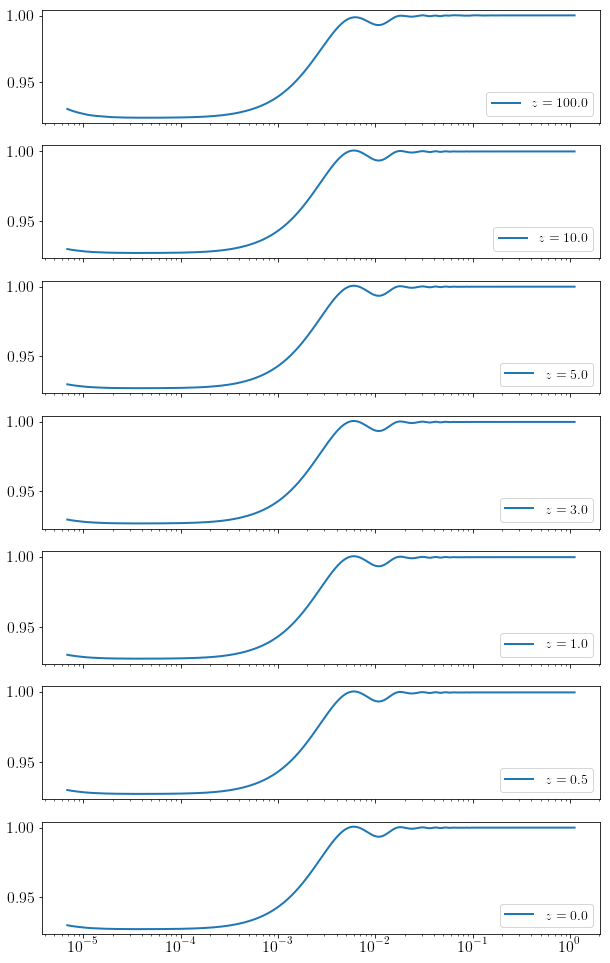

In [81]:
f, axes = plt.subplots(len(zvec),1,figsize=(10,17),sharex=True)
bg = cosmo.get_background()
D = interpolate.UnivariateSpline(1./(1+bg['z']),bg['grow']/bg['grow'][-1],s=0)

tk0 = cosmo.get_transfer(0.)

print bg.keys()
for iz, z in enumerate(zvec):
    a = 1./(1.+z)
    tk = cosmo.get_transfer(z)
    k = tk['k (h/Mpc)']*cosmo.h()
    delta_N = tk['delta_N']
    delta_Nbs = (tk0['delta_N']-k*tk0['L'])*D(a)
    #axes[iz].loglog(k,-delta_N/k/k)
    #axes[iz].loglog(k,-delta_Nbs/k/k)
    axes[iz].semilogx(k,delta_N/delta_Nbs,label=r'$z = '+str(z)+'$')
    axes[iz].legend(loc='lower right')
f.savefig('delta_Nbs.pdf')

0.0155664646688 1.00075057678
0.0150820267294 -0.00129350885898 -1.17377788473
1.95881002356e-05 1.00079551703
1.94838077289e-05 -0.0116510329678 -1.20793120769
3.20407861221e-06 1.00049107419
3.16190938813e-06 -0.0213008570848 -1.222474002
9.74190481949e-07 1.00034088623
9.36862471568e-07 -0.0317838129237 -1.24235610447
1.53318399476e-07 1.00019953492
1.17107758236e-07 -0.0608354944336 -1.34826754253
8.55645934466e-08 1.00017255549
4.94048587514e-08 -0.0767014180789 -1.45725167214
5.07792694159e-08 1.00015677149
1.46384660426e-08 -0.0987574850868 -1.70856047646


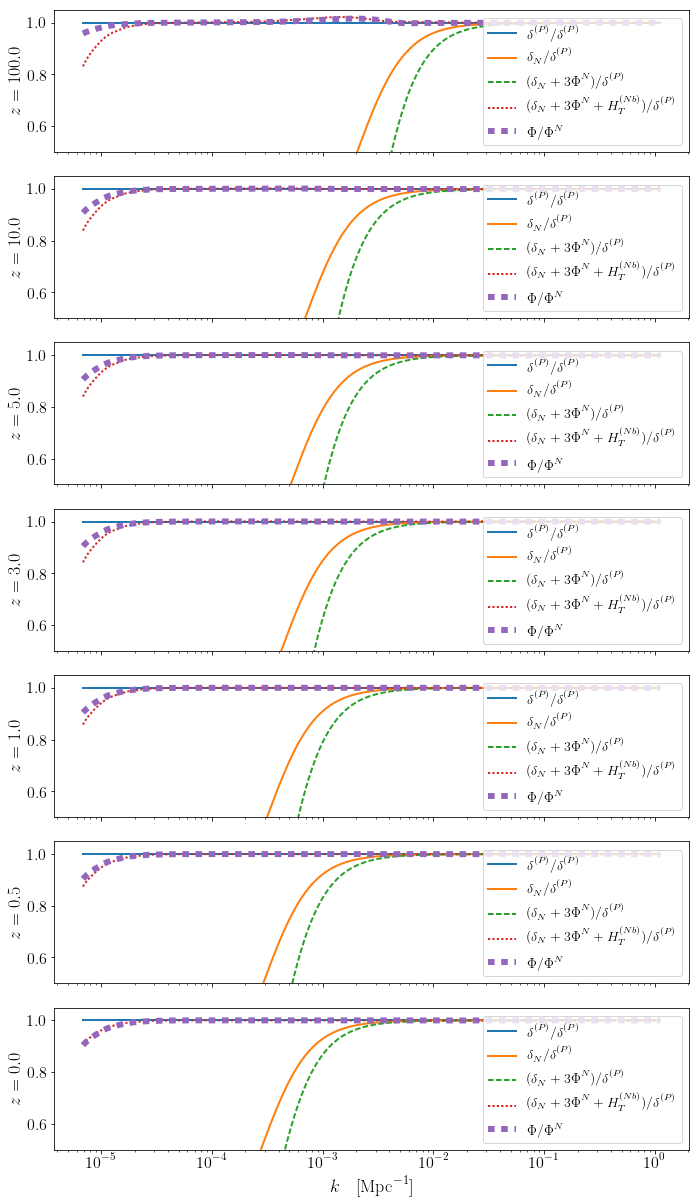

In [120]:
zvec = z_pk
f, axes = plt.subplots(len(zvec),1,figsize=(10,17),sharex=True,sharey=True)
tk0 = cosmo.get_transfer(0.)
bg = cosmo.get_background()
D = interpolate.UnivariateSpline(1./(1+bg['z']),bg['grow']/bg['grow'][-1],s=0)

Hubble = interpolate.UnivariateSpline(1./(1+bg['z']),bg['H [1/Mpc]'],s=0,k=1)
Hubble_prime = interpolate.UnivariateSpline(1./(1+bg['z']),bg['H_prime'],s=0,k=1)


CHT_grow0 = tk0['delta_Nb']
CHT_decay0 = tk0['theta_Nb']

for iz, z in enumerate(zvec):
    a = 1./(1.+z)
    tk = cosmo.get_transfer(z)
    k = tk['k (h/Mpc)']*cosmo.h()
    CHT_grow = tk['delta_Nb']
    CHT_decay = tk['theta_Nb']
    H_T_nb = tk['L_prime']
    L = tk['L']
    H_T_nm = H_T_nb - k*L
    H_T_bs = H_T_nb + (CHT_grow-CHT_grow0)*grow_interp_z(z)+(CHT_decay - CHT_decay0)*decay_interp_z(z)
 
    #delta_N = tk['delta_N']
    delta_N = (tk0['delta_N']-k*tk0['L'])*D(a)
    rho_cdm = rho_cdm_interp_z(z)
    rho_b = rho_b_interp_z(z)
    rho_lambda = rho_lambda_interp_z(z)
    Phi_N = -3./(2.*k**2)*a*a*(rho_cdm+rho_b)*delta_N
    
    #phi = -3./(2.*k**2)*a*a*(tk['d_tot']*(rho_cdm+rho_b)-2*Hubble(a)*Hubble_prime(a)*tk['t_tot']/k/k)
    phi = -3./(2.*k**2)*a*a*(tk['d_tot']*(Hubble(a)**2-rho_lambda)-2*Hubble(a)*Hubble_prime(a)*tk['t_tot']/k/k)
    
    print Hubble(a)**2,phi[100]/Phi_N[100]
    print (rho_cdm+rho_b),delta_N[100],tk['d_tot'][100]
    
    delta_P = (rho_cdm*tk['d_cdm']+rho_b*tk['d_b'])/(rho_cdm+rho_b)
    
    axes[iz].semilogx(k,delta_P/delta_P,label=r'$\delta^{(P)}/\delta^{(P)}$')
    axes[iz].semilogx(k,delta_N/delta_P,label=r'$\delta_N/\delta^{(P)}$')
    axes[iz].semilogx(k,(delta_N+3*Phi_N)/delta_P,label=r'$(\delta_N + 3\Phi^N)/\delta^{(P)}$',ls='--')
    axes[iz].semilogx(k,(delta_N+3*Phi_N+H_T_nb)/delta_P,label=r'$(\delta_N + 3\Phi^N + H_T^{(Nb)})/\delta^{(P)}$',ls=':')
    axes[iz].semilogx(k,phi/Phi_N,label=r'$\Phi/\Phi^N$',ls=':',lw=6)
    
    axes[iz].legend(loc='lower right')
    axes[iz].set_ylabel(r'$z='+str(z)+'$')

axes[-1].set_xlabel(r'$k\quad[\mathrm{Mpc}^{-1}]$')
#axes[-1].set_xlim([1.5e-3,1.0])
axes[-1].set_ylim([0.5,1.05])

f.tight_layout()
f.savefig('delta3b.pdf')

In [83]:
print tk0.keys()
print bg.keys()

['t_ur', 'delta_N', 't_cdm', 'theta_Nb', 't_b', 'd_tot', 'L_prime', 't_g', 'L', 'theta_N', 'd_ur', 'delta_Nb', 'd_cdm', 'd_b', 't_tot', 'd_g', 'k (h/Mpc)']
['(.)rho_crit', 'grow_prime', 'bwdec', '(.)rho_cdm', 'H_prime', '(.)rho_ur', 'ang.diam.dist.', 'proper time [Gyr]', 'H [1/Mpc]', 'conf. time [Mpc]', 'bwdec_prime', 'lum. dist.', 'gr.fac. f', 'comov.snd.hrz.', 'grow', 'comov. dist.', 'Wronskian', '(.)rho_lambda', 'decay', '(.)rho_b', '(.)rho_g', 'gr.fac. D', 'z']


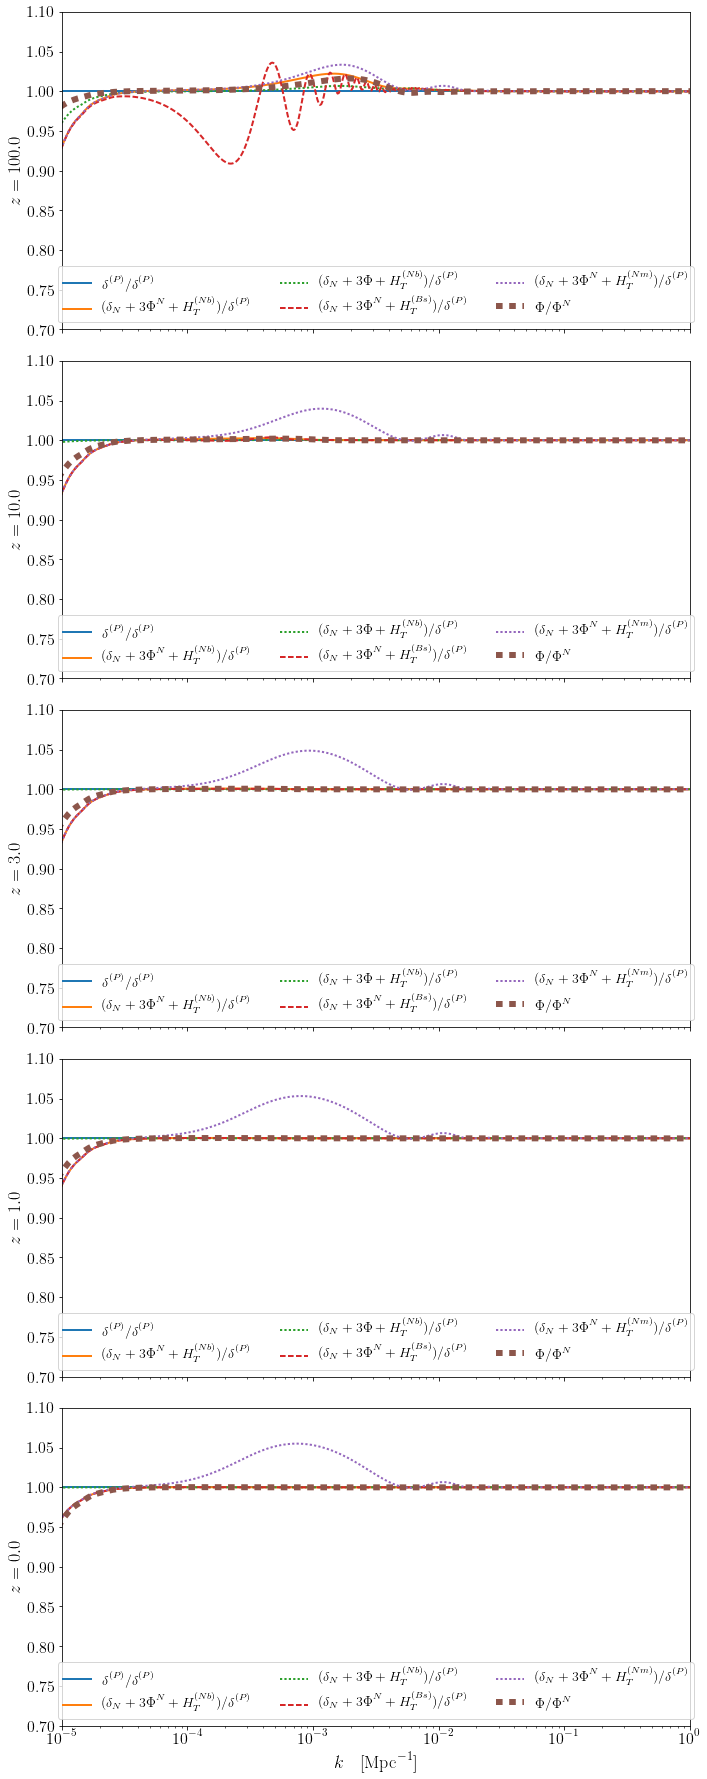

In [132]:
zvec = z_pk
zvec = [100.0,10.0,3.0,1.0,0.0]
f, axes = plt.subplots(len(zvec),1,figsize=(10,25),sharex=True,sharey=True)
tk0 = cosmo.get_transfer(0.)
bg = cosmo.get_background()
D = interpolate.UnivariateSpline(1./(1+bg['z']),bg['grow']/bg['grow'][-1],s=0)

Hubble = interpolate.UnivariateSpline(1./(1+bg['z']),bg['H [1/Mpc]'],s=0,k=1)
Hubble_prime = interpolate.UnivariateSpline(1./(1+bg['z']),bg['H_prime'],s=0,k=1)


CHT_grow0 = tk0['delta_Nb']
CHT_decay0 = tk0['theta_Nb']

for iz, z in enumerate(zvec):
    a = 1./(1.+z)
    tk = cosmo.get_transfer(z)
    k = tk['k (h/Mpc)']*cosmo.h()
    CHT_grow = tk['delta_Nb']
    CHT_decay = tk['theta_Nb']
    H_T_nb = tk['L_prime']
    L = tk['L']
    H_T_nm = H_T_nb - k*L
    H_T_bs = H_T_nb + (CHT_grow-CHT_grow0)*grow_interp_z(z)+(CHT_decay - CHT_decay0)*decay_interp_z(z)
 
    #delta_N = tk['delta_N']
    delta_N = (tk0['delta_N']-k*tk0['L'])*D(a)
    rho_cdm = rho_cdm_interp_z(z)
    rho_b = rho_b_interp_z(z)
    rho_g = rho_g_interp_z(z)
    rho_ur = rho_ur_interp_z(z)
    rho_lambda = rho_lambda_interp_z(z)
    Phi_N = -3./(2.*k**2)*a*a*(rho_cdm+rho_b)*delta_N
    
    phi = -3./(2.*k**2)*a*a*(tk['d_tot']*(rho_cdm+rho_b+rho_g+rho_ur)-2*Hubble(a)*Hubble_prime(a)*tk['t_tot']/k/k)
    #phi = -3./(2.*k**2)*a*a*(tk['d_tot']*(Hubble(a)**2-rho_lambda)-2*Hubble(a)*Hubble_prime(a)*tk['t_tot']/k/k)
    
    #print Hubble(a)**2,phi[100]/Phi_N[100]
    #print (rho_cdm+rho_b),delta_N[100],tk['d_tot'][100]
    
    delta_P = (rho_cdm*tk['d_cdm']+rho_b*tk['d_b'])/(rho_cdm+rho_b)
    
    axes[iz].semilogx(k,delta_P/delta_P,label=r'$\delta^{(P)}/\delta^{(P)}$')
    axes[iz].semilogx(k,(delta_N+3*Phi_N+H_T_nb)/delta_P,label=r'$(\delta_N + 3\Phi^N + H_T^{(Nb)})/\delta^{(P)}$',ls='-')
    axes[iz].semilogx(k,(delta_N+3*phi+H_T_nb)/delta_P,label=r'$(\delta_N + 3\Phi + H_T^{(Nb)})/\delta^{(P)}$',ls=':')
    axes[iz].semilogx(k,(delta_N+3*Phi_N+H_T_bs)/delta_P,label=r'$(\delta_N + 3\Phi^N + H_T^{(Bs)})/\delta^{(P)}$',ls='--')
    axes[iz].semilogx(k,(delta_N+3*Phi_N+H_T_nm)/delta_P,label=r'$(\delta_N + 3\Phi^N + H_T^{(Nm)})/\delta^{(P)}$',ls=':')
    axes[iz].semilogx(k,phi/Phi_N,label=r'$\Phi/\Phi^N$',ls=':',lw=6)
    
    axes[iz].legend(loc='lower center',ncol=3)
    axes[iz].set_ylabel(r'$z='+str(z)+'$')

axes[-1].set_xlabel(r'$k\quad[\mathrm{Mpc}^{-1}]$')
axes[-1].set_xlim([1e-5,1.0])
axes[-1].set_ylim([0.7,1.1])

f.tight_layout()
f.savefig('delta5.pdf')

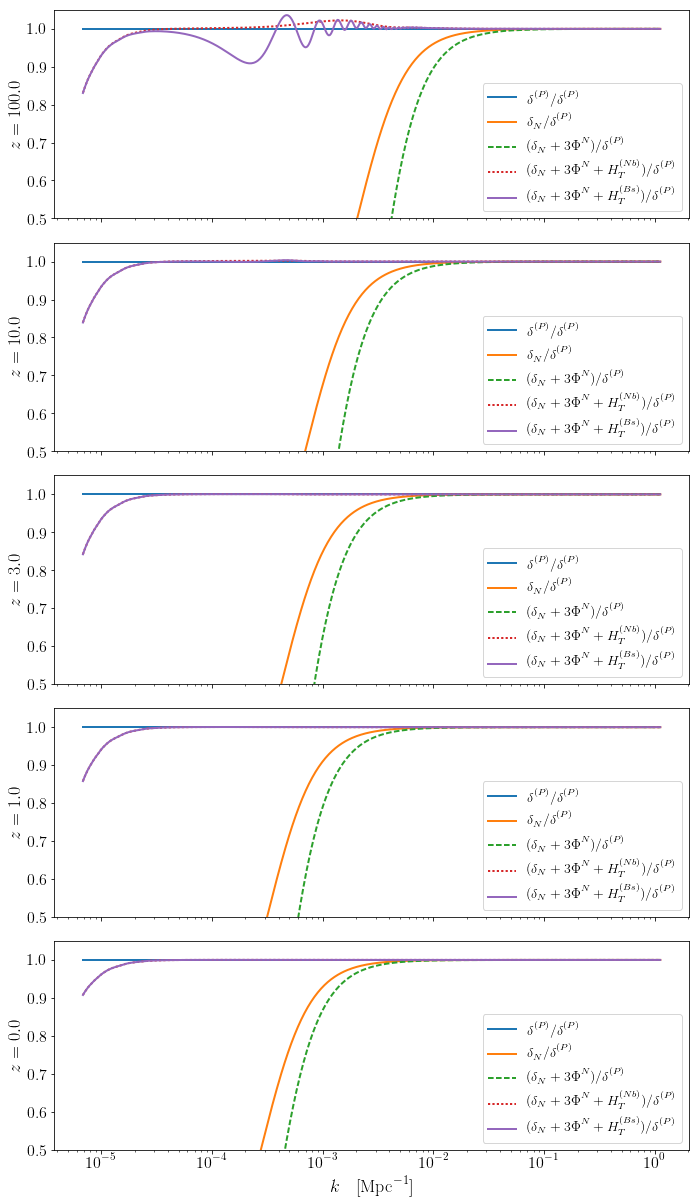

In [135]:
zvec = z_pk
zvec = [100.0,10.0,3.0,1.0,0.0]

f, axes = plt.subplots(len(zvec),1,figsize=(10,17),sharex=True,sharey=True)
tk0 = cosmo.get_transfer(0.)
bg = cosmo.get_background()
D = interpolate.UnivariateSpline(1./(1+bg['z']),bg['grow']/bg['grow'][-1],s=0)

Hubble = interpolate.UnivariateSpline(1./(1+bg['z']),bg['H [1/Mpc]'],s=0,k=1)
Hubble_prime = interpolate.UnivariateSpline(1./(1+bg['z']),bg['H_prime'],s=0,k=1)


CHT_grow0 = tk0['delta_Nb']
CHT_decay0 = tk0['theta_Nb']

for iz, z in enumerate(zvec):
    a = 1./(1.+z)
    tk = cosmo.get_transfer(z)
    k = tk['k (h/Mpc)']*cosmo.h()
    CHT_grow = tk['delta_Nb']
    CHT_decay = tk['theta_Nb']
    H_T_nb = tk['L_prime']
    L = tk['L']
    H_T_nm = H_T_nb - k*L
    H_T_bs = H_T_nb + (CHT_grow-CHT_grow0)*grow_interp_z(z)+(CHT_decay - CHT_decay0)*decay_interp_z(z)
 
    #delta_N = tk['delta_N']
    delta_N = (tk0['delta_N']-k*tk0['L'])*D(a)
    rho_cdm = rho_cdm_interp_z(z)
    rho_b = rho_b_interp_z(z)
    rho_lambda = rho_lambda_interp_z(z)
    Phi_N = -3./(2.*k**2)*a*a*(rho_cdm+rho_b)*delta_N
    
    #phi = -3./(2.*k**2)*a*a*(tk['d_tot']*(rho_cdm+rho_b)-2*Hubble(a)*Hubble_prime(a)*tk['t_tot']/k/k)
    phi = -3./(2.*k**2)*a*a*(tk['d_tot']*(Hubble(a)**2-rho_lambda)-2*Hubble(a)*Hubble_prime(a)*tk['t_tot']/k/k)
    
    delta_P = (rho_cdm*tk['d_cdm']+rho_b*tk['d_b'])/(rho_cdm+rho_b)
    
    axes[iz].semilogx(k,delta_P/delta_P,label=r'$\delta^{(P)}/\delta^{(P)}$')
    axes[iz].semilogx(k,delta_N/delta_P,label=r'$\delta_N/\delta^{(P)}$')
    axes[iz].semilogx(k,(delta_N+3*Phi_N)/delta_P,label=r'$(\delta_N + 3\Phi^N)/\delta^{(P)}$',ls='--')
    axes[iz].semilogx(k,(delta_N+3*Phi_N+H_T_nb)/delta_P,label=r'$(\delta_N + 3\Phi^N + H_T^{(Nb)})/\delta^{(P)}$',ls=':')
    axes[iz].semilogx(k,(delta_N+3*Phi_N+H_T_bs)/delta_P,label=r'$(\delta_N + 3\Phi^N + H_T^{(Bs)})/\delta^{(P)}$',ls='-')
    #axes[iz].semilogx(k,phi/Phi_N,label=r'$\Phi/\Phi^N$',ls=':',lw=6)
    
    axes[iz].legend(loc='lower right')
    axes[iz].set_ylabel(r'$z='+str(z)+'$')

axes[-1].set_xlabel(r'$k\quad[\mathrm{Mpc}^{-1}]$')
#axes[-1].set_xlim([1.5e-3,1.0])
axes[-1].set_ylim([0.5,1.05])

f.tight_layout()
f.savefig('delta_final.pdf')

In [136]:
tk0.keys()

['t_ur',
 'delta_N',
 't_cdm',
 'theta_Nb',
 't_b',
 'd_tot',
 'L_prime',
 't_g',
 'L',
 'theta_N',
 'd_ur',
 'delta_Nb',
 'd_cdm',
 'd_b',
 't_tot',
 'd_g',
 'k (h/Mpc)']